# Notes to Online Course [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/)

***It serves as a shorter version of the course note for readers in a hurry. However it is always recommended to read the excellent original course notes.***

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
#import seaborn as sb
import numpy as np
from scipy import misc
from scipy import spatial
import cPickle
import chainer

## Building Blocks

### Numpy Broadcasting

**Functions that support broadcasting are called universal functions**. Broadcasting two arrays together follows these rules:

1. If the arrays do not have the same rank, prepend the shape of the lower rank array with 1s until both shapes have the same length.
2. The two arrays are said to be compatible in a dimension if they have the same size in the dimension, or if one of the arrays has size 1 in that dimension.
3. The arrays can be broadcast together if they are compatible in all dimensions.
4. After broadcasting, each array behaves as if it had shape equal to the elementwise maximum of shapes of the two input arrays.
5. In any dimension where one array had size 1 and the other array had size greater than 1, the first array behaves as if it were copied along that dimension
6. For common cases of 2D array, a simpler way to remember is that vectors can only broadcasted along vertical axis to form a matrix.

[graph illustration about broadcasting in numpy array](http://wiki.scipy.org/EricsBroadcastingDoc)

By using `reshape` and `broadcasting` (or `tile`), a lot operations can be done easily

### read, write and resize images with `scipy.misc`
1. imread read images into ubytes (equvilant of skimage) - jpeg, png
2. tint the color of images by mulitplying an image with color channel vector (broadcasting)

### matlab files
1. functions `scipy.io.loadmat` and `scipy.io.savemat` to read and write matlab files

### pairwise distance between sets of points
1. `scipy.spatial.distance.pdist` computes all pairs of points in the same set (rows of design matrix)
2. `scipy.spatial.distance.cdist` computes all pairs of points in two sets (rows of two design matrices)
3. `sklearn.utils` has more support on distance calculations

In [2]:
## examples
x = np.array([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]]) ## dimension (4, 3)
y = np.array([1, 0, 1]) ## dimension (3, )
## x+y would do broadcasting as prompt y's dimension to (1, 3), then do elementwise addition by copying y's elements
x + y == x + np.tile(y, (4, 1))

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]], dtype=bool)

In [3]:
## applications
## 1. output product of two vectors - so x will be a column vector, y will be a row vector
x = np.array([1, 2, 3]) # (3, )
y = np.array([2, 5]) # (2, )
print x.reshape((-1, 1)) * y 
## 2. add a vector to each row of a matrix - natural way of broadcasting
M = np.array([[1, 2, 3], [4, 5, 6]]) # (2, 3)
print M + x
## 3. add a vector to each column of a matrix
print y.reshape((-1, 1)) + M
## or 
print (M.T+y).T

[[ 2  5]
 [ 4 10]
 [ 6 15]]
[[2 4 6]
 [5 7 9]]
[[ 3  4  5]
 [ 9 10 11]]
[[ 3  4  5]
 [ 9 10 11]]


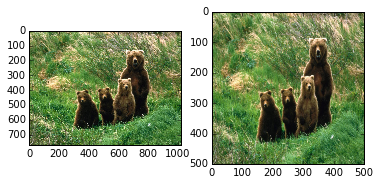

In [4]:
## read resize images
bears = misc.imread("../data/images/many-bears.jpg")
bears.shape, bears.dtype

fig, ax = plt.subplots(1, 2, figsize = (6, 3))
ax[0].imshow(bears)
ax[1].imshow(misc.imresize(bears, (500, 500, 3)))

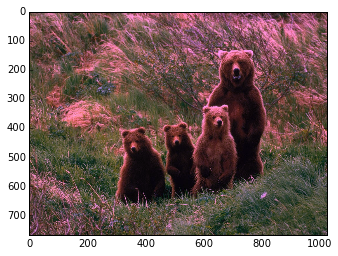

In [5]:
## tint the color of images
bears_tinted = bears * [1., 0.6, 1.] ## make it less green
#plt.imshow(bears_tinted.astype(np.ubyte))
plt.imshow(bears_tinted.astype(np.ubyte))

## Image Classification & kNN

### Image Classification
- Many computer vision tasks are related to labelling images (or regions) from a fixed set.
- the biggest challenges is to design a classier that is insensitive to intra-class variations (e.g., viewpoint, illumiation and etc) whereas sensitive to inter-class variations. (http://cs231n.github.io/classification/)

### KNN
- the L2 distance is much more unforgiving than the L1 distance when it comes to differences between two vectors. That is, the L2 distance prefers many medium disagreements to one big one. 
- *hyperparameter tuning by validation*: In practice. In practice, people prefer to avoid cross-validation in favor of having a single validation split, since cross-validation can be computationally expensive. The splits people tend to use is between 50%-90% of the training data for training and rest for validation. However, this depends on multiple factors: For example if the number of hyperparameters is large you may prefer to use bigger validation splits. If the number of examples in the validation set is small (perhaps only a few hundred or so), it is safer to use cross-validation. Typical number of folds you can see in practice would be 3-fold, 5-fold or 10-fold cross-validation.
- [Fast Library for Approximate Nearest Neighbors](http://www.cs.ubc.ca/research/flann/)
    - FLANN_DIST_EUCLIDEAN = 1, // squared euclidean distance
    - FLANN_DIST_MANHATTAN = 2,
    - FLANN_DIST_MINKOWSKI = 3,
    - FLANN_DIST_HIST_INTERSECT = 5,
    - FlANN_DIST_HELLINGER = 6,
    - FLANN_DIST_CHI_SQUARE = 7, // chi-square
    - FLANN_DIST_KULLBACK_LEIBLER = 8, // kullback-leibler divergence
    
    
    - FLANN_INDEX_LINEAR = 0,
    - FLANN_INDEX_KDTREE = 1,
    - FLANN_INDEX_KMEANS = 2,
    - FLANN_INDEX_COMPOSITE = 3,
    - FLANN_INDEX_KDTREE_SINGLE = 3
    - FLANN_INDEX_SAVED = 254,
    - FLANN_INDEX_AUTOTUNED = 255
- The Nearest Neighbor Classifier may sometimes be a good choice in some settings (especially if the data is low-dimensional), but it is rarely appropriate for use in practical image classification settings. One problem is that images are high-dimensional objects (i.e. they often contain many pixels), and distances over high-dimensional spaces can be very counter-intuitive. 

### kNN in practice
1. Like many other machine learning algorithms that are directly based on distance comparisons, "feature whitening" (making each individual feature zero-mean and one-std) is the key. For special distance metrics, e.g., cosine distance, "normalizing each instance" is good enough.
2. kNN generally performs bad in high-dimension space, considiering dimension reduction by [PCA](http://cs229.stanford.edu/notes/cs229-notes10.pdf) or [Random Projections](http://scikit-learn.org/stable/modules/random_projection.html) - pairwise distances are maximumly perserved.
3. For large dataset, consider use approximate fast kNN, such as [FLANN](http://www.cs.ubc.ca/research/flann/) or LHS.

### Applying cross-validation in general
1. General Scenario: you train your model on metric A and what you really care about is metric B. And you have one or several level parameters to control the complexity of model, and thus essentially the discrepency of A and B.
2. Examples:
    a. A = training error, B = out-of-sample error
    b. A = classification rate, B = cost combined with classification accuracy
    c. A = RMSE, B = MAE
3. Generarlly you should train your model with metric A on a training set, tune the parameter and cross-valiate with metric B on either training or validation set.

### Image Data Preprocessing
 In Machine Learning, it is a very common practice to ***always perform normalization*** of your input features (in the case of images, every pixel is thought of as a feature). In particular, it is important to ***center*** your data by subtracting the mean from every feature. In the case of images, this corresponds to computing a mean image across the training images and subtracting it from every image to get images where the pixels range from approximately [-127 ... 127]. Further common preprocessing is to scale each input feature so that its values range from [-1, 1]. Of these, zero mean centering is arguably more important but we will have to wait for its justification until we understand the dynamics of gradient descent.

### Further Reading
- [A Few Useful Things to Know about Machine Learning](http://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf), where especially section 6 is related but the whole paper is a warmly recommended reading.
- [Recognizing and Learning Object Categories](http://people.csail.mit.edu/torralba/shortCourseRLOC/index.html), a short course of object categorization at ICCV 2005

In [3]:
## hand made knn for cifar 10

def load_cifar_train():
    imgpath = "../data/cifar-10-batches-py/"
    image_batchs, label_batchs = [], []
    for f in ["data_batch_%i" for i in range(1, 6)]:
        batch = cPickle.load(open("../data/cifar-10-batches-py/data_batch_1"))
        image_batchs.append(np.array([np.transpose(r.reshape((3, 32, 32)), (1, 2, 0)).ravel() for r in batch["data"]]))
        label_batchs.append(np.array(batch["labels"]))
    images = np.concatenate(image_batchs, axis = 0)
    labels = np.concatenate(label_batchs, axis = 0)
    return (images, labels)

def load_cifar_test():
    batch = cPickle.load(open("../data/cifar-10-batches-py/test_batch"))
    images = np.array([np.transpose(r.reshape((3, 32, 32)), (1, 2, 0)).ravel() for r in batch["data"]])
    labels = np.array(batch["labels"])
    return (images, labels)

In [4]:
cifar_train_images, cifar_train_labels = load_cifar_train()
cifar_test_images, cifar_test_labels = load_cifar_test()

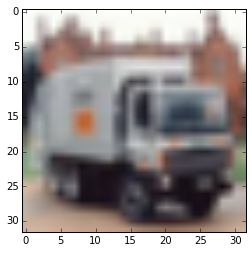

In [4]:
plt.imshow(cifar_test_images[11].reshape((32, 32, 3)))

In [9]:
class NearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_, self.y_ = X, y
    def predict(self, X):
        dists = spatial.distance.cdist(X, self.X_, metric = "cityblock")
        min_index = np.argmin(dists, axis = 1)
        yhat = self.y_[min_index]
        return yhat

In [10]:
nn = NearestNeighbor()
nn.train(cifar_train_images[:5000, :], cifar_train_labels[:5000])
predicted_labels = nn.predict(cifar_test_images[:500, :])
np.mean(predicted_labels==cifar_test_labels[:500])

0.28999999999999998

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, p=1, )
knn.fit(cifar_train_images[:5000, :], cifar_train_labels[:5000])
predicted_labels = knn.predict(cifar_test_images[:500, :])
np.mean(predicted_labels==cifar_test_labels[:500])

0.28999999999999998

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7, p=1, )
knn.fit(cifar_train_images[:5000, :], cifar_train_labels[:5000])
predicted_labels = knn.predict(cifar_test_images[:500, :])
np.mean(predicted_labels==cifar_test_labels[:500])

0.30199999999999999

In [13]:
import pyflann as pf
from scipy import stats

class NearestNeighbor(object):
    def __init__(self, k = 5, algorithm="kdtree"):
        pf.set_distance_type("manhattan")
        self.flann = pf.FLANN()
        self.k = k
        self.algorithm = algorithm
        self.iterations = 7
    def train(self, X, y):
        self.X_, self.y_ = X, y
    def predict(self, X):
        min_index, dists = self.flann.nn(self.X_, X, self.k, 
                                         algorithm = self.algorithm, 
                                         iterations=self.iterations)
        yhat = stats.mode(self.y_[min_index], axis = 1)[0].ravel()
        return yhat
    
nn = NearestNeighbor(k = 3)
nn.train(cifar_train_images, cifar_train_labels)
%time predicted_labels = nn.predict(cifar_test_images)
np.mean(predicted_labels==cifar_test_labels)

CPU times: user 9.23 s, sys: 274 ms, total: 9.5 s
Wall time: 7.44 s


0.26869999999999999

## Linear Models for Classifications
1. For a lot of machine learning problems, `Penalized Linear Models` and `Ensembels` are usually among top list. `Deep Learning` is a new competitor for certain tasks such as image, speech and texts.
2. Penalized linear models are specially useful when the data design matrix is ***fat*** (with more features than data examples), where even ordinary linear models are "too complex" for the data to be overfitted.

### 1. SVM Classifier - linear score function and hinge loss

####**Score Function**
a score function that maps the raw data to class scores, for linear model, it is $f(x_i, W, b) = (Wx_i+b)$

####**Loss Function** 

a loss function that quantifies the agreement between the predicted scores and the ground truth labels.

- ***Multiclass Support Vector Machine Loss***: The SVM loss is set up so that the model "wants" the correct class for each image to have a score higher than all the incorrect classes **by some fixed margin $\Delta$**. It is formalized as $L_i=\sum_{j \neq y_i}{\max (0, f(x_i, W)_j-f(x_i, W)_{y_i}+\Delta)}$. So e.g., if the score function output from model is [13, -7, 11] and the true class is $y_i=0$, and the hyperparameter $\Delta=10$, then the loss will be $L_i = \max(0, -7-13+10) + \max(0, 11-13+10)$
- the above multiclass SVM loss at threshold 0 is usually called ***hinge loss***, i.e., $\max(0, -)$.
- For some dataset, instead using the standandard hinge loss, the ***squared hinge loss*** ${\max(0, -)}^2$ can achieve better results - the final judge would be via cross validation
- ***Regularization***: even linear models can sometime be overfitted - e.g., when there are more features than instances in the dataset. The most common reguarlization penalty term is the $L2$ norm, $R(W) = \sum_k\sum_l{W_{k,l}^2}$. Using a regularization term leads to other good characterirstics, such as ***max margin*** property in SVM.
- an $L2$ norm penalty essentially means that no input dimension can have a very large influence on the scores all by itself, since the L2 penalty prefers smaller and more diffuse weight vectors. That helps to alleviate the *overfitting*. **Note that biases do not have the same effect since, unlike the weights, they do not control the strength of influence of an input dimension. Therefore, it is common to only regularize the weights $W$ but not the biases $b$.  However, in practice this often turns out to have a negligible effect.**
- Putting together,  the multiclass supoort vector machine loss consists of a data loss term and a penalty term as $L = \frac {1}{N} \sum_iL_i + \lambda R(W)$

#### Interpretation of Linear Model 
Based on this decomposition, the linear models can actually be interpreted as **template matching**, whereas each row of weight matrix $W$ is a template in the input space, to be compared with the images. Those templates are independent of each other. So with linear models, we are still effectively doing *Nearest Neighbor*, but instead of having thousands of training images we are only using a single image per class (although we will learn it, and it does not necessarily have to be one of the images in the training set), and we use the *(negative - the higher the better) inner product* as the distance instead of the *L1* or *L2* distance. The bias term is just used to compensate for the different means in each group of image - so that the inner product distance makes sense - it can be resolved in the augumented input space.

#### Multiclass Hinge Loss in Practice
- Hyperparameters $\Delta$ and $\lambda$ have the same role of controlling the tradeoff between data-related loss and weights penalty. So it is almost always safe to use $\Delta=1$ and use cross validation to find $\lambda$ in practice.
- *Relation to traditioanl hinge loss for binary classification*: The traditional hinge loss for binary classification has the form $L_i=C \max(0, 1-y_i w^T x_i) + R(W)$, where $y_i \in [-1, 1]$ It can be viewed as a special case of the multiclass hinge loss introduced above, as here $\frac{1}{2}w^Tx$ encodes the score for $y=1$, and the score for $y=-1$ is $- \frac{1}{2}w^Tx$.
- Other variaties of one-vs-all and all-vs-all multiple classification losses can be found in pratice. Good comparisons can be found in [1](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es1999-461.pdf) and [2](http://www.jmlr.org/papers/volume5/rifkin04a/rifkin04a.pdf).


### 2. Softmax Classifier - logitstic score function and cross-entropy loss
Softmax Classifier is the genearlization of *logistic regression* (with logistic function as activation) to multiple classification problems.

#### **Score function**
The score function in softmax classifier is the same as the one used in SVM - a linear function $f(x_i, W, b) = Wx_i + b$. However, as the reason described below, its interpretation is more intutive - it is the un-normalized log probabilities for each class

#### **Loss function**
With softmax classifier is the ***Cross Entropy Loss*** that is based on the ***softmax function***, it has the form
$L_i=- \log (\frac {e^{f_{y_i}}} {{\sum_j{e^{f_j}} } })$ or equivalently $L_i = -f_{y_i} + \log \sum_j {e^{f_j}}$. As before, the full loss for the dataset is the ***mean*** of $L_i$ together with a regularization term $R(W)$. The function $f_j(z)=\frac {e^{z_j}} {\sum_k {e^{z_k}} }$ is called ***softmax function***. It has the name because it takes a vector of arbitrary real-valued scores and squarshes it to a vector of values between zero and one that sum to one.

#### **Interpretation of Softmax Classifier**
- **Information Theory**
    1. The *Corss-Entropy* between a true distribution $p$ and an estimated distribution $q$ is defined as $H(p, q) = - \sum_x {p(x)\log q(x)}$. It can also be written in terms of entropy and Kullback-Leibler divergence as $H(p, q) = H(p) + D_{KL}(p||q)$. So minimizing the cross-entropy between two distributions is equivalent to minimizing their KL divergence.
    2. In the case of softmax classifier, the estimated class probability $q = \frac {e^{f_{y_i}}} {\sum_j {e^{f_j}}}$, whereas the true distribution is the distribution where all probability mass is on the correct class, i.e., $p = [0, ..., 1, ..., 0]$ contains a single 1 at the $y_i$th position.
    3. In other words, the cross-entropy objective wants the predicted distribution to have all of its mass onthe correct answer.
- **Probabilistic View**
    1. As memtioned above, the estimated probability for $p(y_i|x_i) = \frac {e^{f_{y_i}}} {\sum_j {e^{f_j}}}$. So the cross-entropy can be interpreted as *negative log likelihood of the correct class*, and the whole loss function with the $L_2$ norm as *Maximum a posteriori* estimation with a Gaussian piror for $W$
- **Output of Softmax as probability estimate**: The softmax classifier can compute the probabilites of different labels, which allows you to interpret its confidence in each class. However, just similiar to SVM, the ordering of the scores is interpretable, but the absolute numbers (or their differences) technically are not. This is because how "peaky" or "diffuse" those probabilites are depends directly on the reguarlization term $\lambda$. Specially, a higher value of $\lambda$ will encourge the probability estimations be more diffuse due to strong regularization $L_2$ norm prefers diffusion in general. As an extrem case, very tiny numbers of weights due to very strong regularization will generate *near-uniform* probability estimates. 
    
#### **Softmax Classifier in Practice**
- when calculating the probability estimation $\frac {e^{f_{y_i}}} {\sum_j {e^{f_j}}}$, the intermediate terms $e^{f_j}$ might be very large due to the exponentials, and dividing large numbers can be numerically unstable - it will cause overflow (Inf). *Underflow is less severe here because exp of a big negative value can be safely treated as zero.*
- the trick is to notice that $\frac {e^{f_{y_i}}} {\sum_j {e^{f_j}}} = \frac {Ce^{f_{y_i}}} {\sum_j {Ce^{f_j}}}$, where $C$ is arbitrary constant. A common choice for $C$ is to set $\log C = - \max_j {f_j}$ - this simply states that we should shift the values in side vector $f$ so that the highest value is zero, and then take the exponential of each, and then normalize them by dividing by their sum.

### 3. SVM v.s. Softmax 
- A good illustration from the original class note <img src="http://cs231n.github.io/assets/svmvssoftmax.png">
- Original explainations for the above illustration: *Example of the difference between the SVM and Softmax classifiers for one datapoint. In both cases we compute the same score vector f (e.g. by matrix multiplication in this section). The difference is in the interpretation of the scores in f: The SVM interprets these as class scores and its loss function encourages the correct class (class 2, in blue) to have a score higher by a margin than the other class scores. The Softmax classifier instead interprets the scores as (unnormalized) log probabilities for each class and then encourages the (normalized) log probability of the correct class to be high (equivalently the negative of it to be low). The final loss for this example is 1.58 for the SVM and 1.04 for the Softmax classifier, but note that these numbers are not comparable; They are only meaningful in relation to loss computed within the same classifier and with the same data.*
- In practice, performance difference between SVM and Softmax are usually very small. However, the nature of the hinge loss decides that SVM is a more *tolerant* model compared to Softmax. This is because in hinge loss, a zero loss can be achieved beyond a margin threshold, whereas the cross-entropy will never be exactly satisfied. This is sometime a blessing to certain problems as it means "distinguishing more similiar classes are more important than distinguishing classes that have already been well separated".
- [An online demo](http://vision.stanford.edu/teaching/cs231n/linear-classify-demo/)
- [An article comparing SVM with Softmax under a deep learning structure](http://arxiv.org/abs/1306.0239)

### 4. Summary and Foreshadowing
- both linear SVM and Softmax classifier use a linear function as a score function to map input vectors to class scores
- Different loss functions can be used for different tasks, e.g., hinge for SVM and cross-entropy for Softmax
- Later we will see that Neural Networks and Convolutional Neural Networks can be viewed as extensions to these models by using a more complicated (usually nonlinear) score function.
- The three main components to traditional machine learning problems: (1) score function (2) loss function and (3) optimization

In [14]:
## implementation of the loss function for multiclass support vector machine loss
## vectorized version, with penalty term
def cost(X, y, W, b, lmbda, delta = 1.):
    """
    X: design matrix, (ninstances, nfeatures)
    y: integer array indicating class labels, (ninstances, )
    W: weights: (nclasses, nfeatures)
    b: biases: nclasses
    delta: threshold for hinge loss
    lmbda: folat hyperparameter to control reguarlization
    """
    score = np.dot(X, W.T) + b # ninstances x nclasses + nclasses
    loss = (score.T - score[np.arange(score.shape[0]), y].T + delta)
    loss = np.maximum(0, loss.T) # ninstances x nclasses
    loss[np.arange(loss.shape[0]), y] = 0
    loss = np.sum(loss) / X.shape[0]
    return loss + lmbda * (W * W).sum()

In [15]:
## normalization trick for implementation of softmax classifier
f = np.array([123, 456, 789])
p = np.exp(f) / np.exp(f).sum() ## BAD: numerically unstale
print p

f = np.array([123, 456, 789])
f -= f.max()
p = np.exp(f) / np.exp(f).sum() ## Normalization trick: numerically safe
print p

[  0.   0.  nan]
[  5.75274406e-290   2.39848787e-145   1.00000000e+000]


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


## Optimization with Gradient Descent

**The ability to compute the gradient of a loss function with respect to its weights (and have some intuitive understanding of it) is the most important skill needed to design, train and understand neural networks.** It needs a good practice as well as tricks such as chain rule (also refered to as **backpropagation**).

### Gradient Descent Optimization
- Given the loss function, many optimization methods can be applied. Among others (e.g., LBFGS), Gradietn Descent is curretnly by far the most common and established way of optimizting Neural Nework loss functions.
- In its basic form, it involves updating the current value of parameter (e.g., $W$) by **substracting** the gradient times a **step size**. Choosing the step size (also called **learning rate**) is one of the most important (amd most headache-inducing) hyperparamter settings in training a neural network - Values that are too small will sacrifice efficiency whereas those that are too big have the risk of overshooting the minima.

### Variations of GD

- Vanilla GD 
```python
# Vanilla Gradient Descent
while True:
  weights_grad = evaluate_gradient(loss_fun, data, weights)
  weights += - step_size * weights_grad # perform parameter update
```   

- Mini-batch GD
In larget scale applications, where training data are of order of millions of examples, it is more convinient to use the *mini-batch gradient descent*. The rational is that the examples in the training data are correlated. So an estimate of gradient based on whole set might be just be a multiples of the gradient estimated based on a subset. Besides it speeds up the learning process. The pesudo-code for this is like

```python
# Vanilla Minibatch Gradient Descent

while True:
  data_batch = sample_training_data(data, 256) # sample 256 examples
  weights_grad = evaluate_gradient(loss_fun, data_batch, weights)
  weights += - step_size * weights_grad # perform parameter update
```
**Even though the mini-batch size is a hyperparameter, it's seldomly decided by cross validation in practice. It is usually based on memory constraints (if any) or set to some value around 100.**

- Stochastic GD
Another extreme case of this is a setting where the mini-batch cnotains only a single example. This is usually called **Stochastic Gradient Descent (SGD)** or sometimes **online gradient descent**. This is relatively less common to see because in practice due to vectorized code optimizations it can be computationally much more efficient to evaluate the gradient for 100 examples, than the gradient for one example 100 times. 

### Calculation of Gradients
There are two ways to compute the gradient: A slow, approximate but easy way (**numerical gradient**), and a fast exact but more error-prone way that requires calculus (**analytic gradient**).

#### Numerical Gradient
1. Numerical Gradient is calculated based on defintion by using a small step_size $h$ (e.g., 1e-5) to approximate its limit towards 0. Addtitionally it can also be caculated by [centered difference formula](http://en.wikipedia.org/wiki/Numerical_differentiation). 
2. As its complexity is linear, it is less common to be used directly in practice.

#### Analytic Gradient
1. Analyitc Gradient involves a close-form for gradients. Its faster to calculate but more error prone.
2. The common practice is to use "Analytic Gradient" for calculation and always use "Numerical Gradient" for **gradient check**.

## Backpropagation (Chain Rule) for Gradient Computing

**Backpropagation** - a way of computing gradients of expressions through *recursive* application of **chain rule**.

**Problem setting**: Given any loss function $f(x)$ where $x$ is a vector, compute the gradient $\nabla f(x)$

The most interesting part from the tutorial is an **intuitive** interpretation of the backpropagation algorithm. Based on that, every expression $f(x)$ is a real-valued circuit composing some simple gate functions such as $add$, $multiply$, $exp$ and $max$. Calculation corresponds to the forward flow of the circuit and gradient is the backward flow. The nice part of this analogy is that the circut has very nice **nature of local computation**. In detials, 
```
Every gate in a circuit diagram gets some inputs and can right away compute two things: 1. its output value and 2. the local gradient of its inputs with respect to its output value. Notice that the gates can do this completely independently without being aware of any of the details of the full circuit that they are embedded in. However, once the forward pass is over, during backpropagation the gate will eventually learn about the gradient of its output value on the final output of the entire circuit. Chain rule says that the gate should take that gradient and multiply it into every gradient it normally computes for all of its inputs.
```

**Commonly Used Gates and their Gradients** - assume the parameter vector is $[x_1, x_2]$
- $f(x_1, x_2) = x_1 * x_2$: $\frac{\partial f}{\partial x_1} = x_2$ Multiplication takes the input activations, swaps them and multiplies by its gradients - the weights are activation inputs, which are swapped in the backforward phase.
- $f(x_1, x_2) = x_1 + x_2$: $\frac{\partial f}{\partial x_1} = 1$ Sum operation distributes gradients equally to all its inputs.
- $f(x_1, x_2) = max(x_1,x_2)$: $\frac{\partial f}{\partial x_1} = 1$ if $x_1 >= x_2$ else $\frac{\partial f}{\partial x_1} = 0$ Max operation routes the gradient to the higher input.

The **break-down of gradient computation as a local process** implies a useful way of calculating function values in forward process and calculating gradient in backword process with staged computations. An example is the sigmoid function $\sigma(x) = \frac{1}{1+e^{-z}} = \frac{1}{1+e^{-w*x}}$. Notice $\frac{\partial \sigma(z)}{\partial z} = (1-\sigma(z))\sigma(z)$. So the forward and backward process would be
``` python
w = [2,-3,-3] # assume some random weights and data
x = [-1, -2]

# forward pass
dot = w[0]*x[0] + w[1]*x[1] + w[2]
f = 1.0 / (1 + math.exp(-dot)) # sigmoid function

# backward pass through the neuron (backpropagation)
ddot = (1 - f) * f # gradient on dot variable, using the sigmoid gradient derivation
dx = [w[0] * ddot, w[1] * ddot] # backprop into x - elementwise
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] # backprop into w - elementwise
# we're done! we have the gradients on the inputs to the circuit
```

In [16]:
## ilustration of f(x,y,z) = (x+y)*z - copied from http://cs231n.github.io/optimization-2/

from IPython.display import HTML, display
display(HTML(r"""
<svg width="420" height="220"><defs><marker id="arrowhead" refX="6" refY="2" markerWidth="6" markerHeight="4" orient="auto"><path d="M 0,0 V 4 L6,2 Z"></path></marker></defs><line x1="40" y1="30" x2="110" y2="30" stroke="black" stroke-width="1"></line><text x="45" y="24" font-size="16" fill="green">-2</text><text x="45" y="47" font-size="16" fill="red">-4</text><text x="35" y="24" font-size="16" text-anchor="end" fill="black">x</text><line x1="40" y1="100" x2="110" y2="100" stroke="black" stroke-width="1"></line><text x="45" y="94" font-size="16" fill="green">5</text><text x="45" y="117" font-size="16" fill="red">-4</text><text x="35" y="94" font-size="16" text-anchor="end" fill="black">y</text><line x1="40" y1="170" x2="110" y2="170" stroke="black" stroke-width="1"></line><text x="45" y="164" font-size="16" fill="green">-4</text><text x="45" y="187" font-size="16" fill="red">3</text><text x="35" y="164" font-size="16" text-anchor="end" fill="black">z</text><line x1="210" y1="65" x2="280" y2="65" stroke="black" stroke-width="1"></line><text x="215" y="59" font-size="16" fill="green">3</text><text x="215" y="82" font-size="16" fill="red">-4</text><text x="205" y="59" font-size="16" text-anchor="end" fill="black">q</text><circle cx="170" cy="65" fill="white" stroke="black" stroke-width="1" r="20"></circle><text x="170" y="70" font-size="20" fill="black" text-anchor="middle">+</text><line x1="110" y1="30" x2="150" y2="65" stroke="black" stroke-width="1" marker-end="url(#arrowhead)"></line><line x1="110" y1="100" x2="150" y2="65" stroke="black" stroke-width="1" marker-end="url(#arrowhead)"></line><line x1="190" y1="65" x2="210" y2="65" stroke="black" stroke-width="1" marker-end="url(#arrowhead)"></line><line x1="380" y1="117" x2="450" y2="117" stroke="black" stroke-width="1"></line><text x="385" y="111" font-size="16" fill="green">-12</text><text x="385" y="134" font-size="16" fill="red">1</text><text x="375" y="111" font-size="16" text-anchor="end" fill="black">f</text><circle cx="340" cy="117" fill="white" stroke="black" stroke-width="1" r="20"></circle><text x="340" y="127" font-size="20" fill="black" text-anchor="middle">*</text><line x1="280" y1="65" x2="320" y2="117" stroke="black" stroke-width="1" marker-end="url(#arrowhead)"></line><line x1="110" y1="170" x2="320" y2="117" stroke="black" stroke-width="1" marker-end="url(#arrowhead)"></line><line x1="360" y1="117" x2="380" y2="117" stroke="black" stroke-width="1" marker-end="url(#arrowhead)"></line></svg>"""))

print """The add gate received inputs [-2, 5] and computed output 3. Since the gate is computing the addition operation, its local gradient for both of its inputs is +1. The rest of the circuit computed the final value, which is -12. During the backward pass in which the chain rule is applied recursively backwards through the circuit, the add gate (which is an input to the multiply gate) learns that the gradient for its output was -4. If we anthropomorphize the circuit as wanting to output a higher value (which can help with intuition), then we can think of the circuit as "wanting" the output of the add gate to be lower (due to negative sign), and with a force of 4. To continue the recurrence and to chain the gradient, the add gate takes that gradient and multiplies it to all of the local gradients for its inputs (making the gradient on both x and y 1 * -4 = -4). Notice that this has the desired effect: If x,y were to decrease (responding to their negative gradient) then the add gate's output would decrease, which in turn makes the multiply gate's output increase."""

The add gate received inputs [-2, 5] and computed output 3. Since the gate is computing the addition operation, its local gradient for both of its inputs is +1. The rest of the circuit computed the final value, which is -12. During the backward pass in which the chain rule is applied recursively backwards through the circuit, the add gate (which is an input to the multiply gate) learns that the gradient for its output was -4. If we anthropomorphize the circuit as wanting to output a higher value (which can help with intuition), then we can think of the circuit as "wanting" the output of the add gate to be lower (due to negative sign), and with a force of 4. To continue the recurrence and to chain the gradient, the add gate takes that gradient and multiplies it to all of the local gradients for its inputs (making the gradient on both x and y 1 * -4 = -4). Notice that this has the desired effect: If x,y were to decrease (responding to their negative gradient) then the add gate's output w

practice of stage-computation (forward and backward) for expression $f(x, y) = \frac {x+\sigma(y)} {\sigma(x) + (x+y)^2}$

**Practice makes perfect**

In [12]:
## example values
x, y = 3, -4

## STAGED forward pass 
sigx = 1. / (1. + np.exp(-x))
sigy = 1. / (1. + np.exp(-y))
xpy = x+y
xpy2 = xpy**2
num = x+sigy
den = sigx + xpy2
invden = 1./ den
f = num * invden

print "forward process", f

## STAGED backward pass- look from bottom up

## f = num * invden - inputs to the backward pass
dnum = invden
dinvden = num
## invden = 1./ den
dden = dinvden * -1. / (den**2)
## den = sigx + xpy2
dsigx = dden * 1.
dxpy2 = dden * 1.
## num = x+sigy
dx = dnum * 1.
dsigy = dnum * 1.
## xpy2 = xpy**2
dxpy = dxpy2 * 2 * xpy
## xpy = x + y
dx += dxpy * 1.
dy = dxpy * 1.
## sigy = \sigma(y)
dy += dsigy * (1.-sigy) * sigy
## sigx = \sgima(x)
dx += dsigx * (1.-sigx) * sigx

print "backward process", dx, dy

## verify
def f(x, y):
    sigx = 1. / (1. + np.exp(-x))
    sigy = 1. / (1. + np.exp(-y))
    xpy = x+y
    xpy2 = xpy**2
    num = x+sigy
    den = sigx + xpy2
    invden = 1./ den
    return num * invden

delta = 1e-5
dx = (f(x+delta, y) - f(x, y)) / delta
dy = (f(x, y+delta) - f(x, y)) / delta

print "verification of derivative by finite difference", dx, dy

forward process 1.54564488411
backward process 2.05956979557 1.59223275148
verification of derivative by finite difference 2.05958266095 1.59224118823


In [9]:
## chainer version
x, y = chainer.Variable(np.array([3], np.float32)), chainer.Variable(np.array([-4], np.float32))
sigx = chainer.functions.sigmoid(x)
sigy = chainer.functions.sigmoid(y)
xpy = x + y
xpy2 = xpy**2
num = x + sigy
den = sigx + xpy2
invden = 1. / den
f = num * invden
print f.data

f.backward(retain_grad=True)
print f.grad, x.grad, y.grad

[ 1.54564488]
[ 1.] [ 2.05956984] [ 1.5922327]


Notice a few things:

**Cache forward pass variables.** To compute the backward pass it is very helpful to have some of the variables that were used in the forward pass. In practice you want to structure your code so that you cache these variables, and so that they are available during backpropagation. If this is too difficult, it is possible (but wasteful) to recompute them. See some [examples](http://karpathy.github.io/neuralnets/) here.

**Gradients add up at forks.** The forward expression involves the variables x,y multiple times, so when we perform backpropagation we must be careful to use += instead of = to accumulate the gradient on these variables (otherwise we would overwrite it). This follows the multivariable chain rule in Calculus, which states that if a variable branches out to different parts of the circuit, then the gradients that flow back to it will add.

**And that is exactly why pre-processing is important.**

*Unintuitive effects and their consequences.* Notice that if one of the inputs to the multiply gate is very small and the other is very big, then the multiply gate will do something slightly unintuitive: it will assign a relatively huge gradient to the small input and a tiny gradient to the large input. Note that in linear classifiers where the weights are dot producted $w^Tx_i$ (multiplied) with the inputs, this implies that the scale of the data has an effect on the magnitude of the gradient for the weights. For example, if you multiplied all input data examples $x_i$ by 1000 during preprocessing, then the gradient on the weights will be 1000 times larger, and you'd have to lower the learning rate by that factor to compensate. This is why preprocessing matters a lot, sometimes in subtle ways! And having intuitive understanding for how the gradients flow can help you debug some of these cases.

***Examples of Gradients for vectorized Operations*** - the most general case would b **Matrix-Matrix multiply gradient**, which generalizes to matrix-vector and vector-vector operations - the tip is *dimension analysis*

```python
## forward pass
W = np.random.randn(5, 10) # 5 x 10
X = np.random.randn(10, 3) # 10 x 3
D = W.dot(X) # 5 x 3

## backward pass
# suppose we have calculated derivative of D from an error function
dD = np.random.randn(*D.shape)
dW = dD.dot(X.T) # dW is of same shape with W, only way to put together is dD.dot(X.T)
dX = W.T.dot(dD) # same reasoning here
```

### Summary
- In practice the back-propogation of gradients (or changes if a learning rate is applied) should always be done in **staged computation**. rucially, you almost never want to write out these expressions on paper and differentiate them symbolically in full, because you never need an explicit mathematical equation for the gradient of the input variables. 
- Use **dimension analysis** for matrix/vector expressions

## Neural Networks

### 1. Architecture
- A single neurou is pretty much a linear classifier. It can be trained with Softmax loss, Binary SVM loss with/without regularization term

#### Common Activation Functions
- **Sigmoid**. math form $\sigma(x) = \frac {1} {1+\exp(-x)}$. It was widely used in the history as the nonlinear activation function, but fell out of favor recently, because of the major drawbacks. <img src="http://cs231n.github.io/assets/nn1/sigmoid.jpeg">
    - *Sigmoids saturate and kill gradients* - when sigmoid neuron's activation saturates at either tail of 0 or 1, the gradient at these regions is almost zero! This is an unpleasant result as the gradient 'backpropogated' through the neuro will be the multiplication of local gradient and output gradient. So as a result, if the local gradient is very small, it effectively kill the flow of gradient to its weights and data. As another caution, initialization of sigmoid neuron's weights to big values will make it effectively saturated - and thus block the gradient.
    - *Sigmoid outputs are not zero-centered* - this is an inconvenience but not too severe in practice. Sigmoid outputs are not zero-centered (they are 0.5 centered). As a result, their outputs are always positive (between 0 and 1). Imagine those outputs become the inputs to neurous of next layer - it will make the local graident vector of those neuros in next layer either all positive or all negative because $f=\sigma(w^Tx+b)$. This zig-zag behavior of gradient may not be desiable in optimization, whereas it will be alleviated by summing up the gradients of a batch of examples. 
- **Tanh**. The shape of Tanh is similiar to sigmoid in that both squeezes real-valued output to a range, [-1, 1] for Tanh and [0, 1] for sigmoid. As such the Tanh activation is zero-centered, but it still suffers from the low gradient around saturated areas. Therefore, in practice *tanh non-linearity is almost always preferred to sigmoid nonlinearity*. <img src="http://cs231n.github.io/assets/nn1/tanh.jpeg">
- **ReLU**. The Rectified Linear Unit is the popular choice in recent years. Mathematically It is $f(x) = max(0, x)$. So its activation is simply thresholded at zero.  Pros and cons of ReLU are, <img src="http://cs231n.github.io/assets/nn1/relu.jpeg">
    - ***Pros***: it is easy to compute (thresholding at 0). It may [converge faster](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf) than Sigmoid/Tanh due to its linearity at the >=0 part.
    - ***Cons***: It is very senstive to the proper setting of learning rate. Recall that the 'max' function will back-flow the gradient to the bigger value - and it will become zero for ReLU, e.g., when a large gradient back-flowing through a ReLU neuron - it will cause the weights to update in such a way that the neuron will never activate on any datapoint again - it stops in the negative part for ever. For example, you may find that as much as 40% of your network can be "dead" (i.e. neurons that never activativate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue.
- **Leaky ReLU**: One possible remedy to ReLU is the leaky version - Instead of the function being zero when x < 0, a leaky ReLU will instead have a small negative slop (e.g. of 0.01). That is, $f(x) = x$ if $x >= 0$; $f(x) = \alpha x$ if $x <0$ with $\alpha = 0.01$
- **Maxout**: Both ReLU and Leaky ReLU can be viewed as special cases of [Maxout](http://www-etud.iro.umontreal.ca/~goodfeli/maxout.html). Mathematically it can be expressed as $\max(w_1^Tx+b_1, w_2^Tx+b_2)$. So e.g. ReLU corresponds to $w_1=0$ and $b_1=0$ and Leaky ReLU corresponds to $w_1 = 0.01w_2$, $b_1=0.01b_2$.  The Maxout neuron therefore enjoys all the benefits of a ReLU unit (linear regime of operation, no saturation) and does not have its drawbacks (dying ReLU). However, unlike the ReLU neurons it doubles the number of parameters for every single neuron, leading to a high total number of parameters.
- **tl;dr**: "What neuron type should I use?" Use the ReLU non-linearity, be careful with your learning rates and possibly monitor the fraction of "dead" units in a network. If this concerns you, give Leaky ReLU or Maxout a try. Never use sigmoid. Try tanh, but expect it to work worse than ReLU/Maxout. As a last comment, it is very rare to mix and match different types of neurons in the same network, even though there is no fundamental problem with doing so.

#### Convention of Neural Network
- Units in NN are usually organized in layers. It is common to see connections only exist across layers but not within a layer.
- We don't count the input layer when say N-layer NN, as such, Softmax/Logistic Regression and SVM are simlay special case of single layer NN.
- It is common that the output layer neurons do not have an activation function (or just as using a linear identity activation). This is because the last output layer is usually taken to represent the class scores (e.g. in classification), which are arbitrary real-valued numbers, or some kind of real-valued target (e.g. in regression). The nature of the problem (classification/regression/unsupervised) is determined by the `cost` function that is used, e.g., SVM hinge loss/Softmax for classification, MSE for regression.
- NN complexity is usually measured by the number of parameters, or sometimes equivallently number of units.
- One of the primary reasons that Neural Networks are organized into layers is that this structure makes it very simple and efficient to evaluate Neural Networks using matrix vector operations, i.e., `The forward pass of a fully-connected layer corresponds to one matrix multiplication followed by a bias offset and an activation function.`
- Convention of matrix (input/parameter) representation in NN: 
    - Input matrix X is of (D, N), where D is the input dimension and N is number of instances in the batch. Note that the representation of X here is the transpose of the design matrix format.
    - In each layer, the weight parameter $W$ is of $(N_{n}, N_{n-1})$, where $N_{n}$ is the number of units in the curretn layer and $N_{n-1}$ is the number of units from the previous layer. The bias $b$ would be of $(N_n, 1)$. So the activation would be $h_n = f(Wh_{n-1}+b)$, where $h_n$ and $h_{n-1}$ are the activations of current and previous layers.
    
#### Representation Power and Complexity Control
- NN with one hidden layer is already a universial approximator, so why go even deeper?  The fact that deeper networks (with multiple hidden layers) can work better than a single-hidden-layer networks is an empirical observation, despite the fact that their representational power is equal.
- However, in practice it is often the case that 3-layer neural networks will outperform 2-layer nets, but going even deeper (4,5,6-layer) rarely helps much more. This is in stark contrast to Convolutional Networks, where depth has been found to be an extremely important component for a good recognition system (e.g. on order of 10 learnable layers) - **One argument for this observation is that images contain hierarchical structure (e.g. faces are made up of eyes, which are made up of edges, etc.), so several layers of processing make intuitive sense for this data domain.** So for different data, we don't generally expect this to be true. e,g, the [word2vector](https://code.google.com/p/word2vec/) (not even deep) performs well on capturing contexts of words and their similarities, whereas theoritically it is equivalanet to a more traditional [matrix factorization approach](https://levyomer.wordpress.com/2015/03/30/improving-distributional-similarity-with-lessons-learned-from-word-embeddings/).
- More on how deep is deep enough, recommended readings: [Do Deep Nets Really Need to be Deep?](http://arxiv.org/abs/1312.6184) and [FitNets: Hints for Thin Deep Nets](http://arxiv.org/abs/1412.6550)
- As for controlling the complexity of a NN to avoid overfitting, in practice, it is always better to use these methods (e.g., l1 or l2 regularization) to control overfitting instead of the number of neurons. Why reason is the counter-intuitive relation between size of nn and its bias-variance balance. From the course note, it says
```The subtle reason behind this is that smaller networks are harder to train with local methods such as Gradient Descent: It's clear that their loss functions have relatively few local minima, but it turns out that many of these minima are easier to converge to, and that they are bad (i.e. with high loss). Conversely, bigger neural networks contain significantly more local minima, but these minima turn out to be much better in terms of their actual loss. Since Neural Networks are non-convex, it is hard to study these properties mathematically, but some attempts to understand these objective functions have been made, e.g. in a recent paper [The Loss Surfaces of Multilayer Networks](http://arxiv.org/abs/1412.0233). In practice, what you find is that if you train a small network the final loss can display a good amount of variance - in some cases you get lucky and converge to a good place but in some cases you get trapped in one of the bad minima. On the other hand, if you train a large network you'll start to find many different solutions, but the variance in the final achieved loss will be much smaller. In other words, all solutions are about equally as good, and rely less on the luck of random initialization.
```
- ***The takeaway is that you should not be using smaller networks because you are afraid of overfitting. Instead, you should use as big of a neural network as your computational budget allows, and use other regularization techniques to control overfitting.***


## Neural Networks
### 2. Data and Loss

#### Data Preprocessing
There are several steps that can be used for data preprocessing, they are:
- ***Feature mean substraction***
    - effect: centerizing data to the origin
    - it is a common mistake to get the mean across train/validation/test data, it should always be calcuating mean only from train data, and applying them globally
    - it is almost always applied on all kinds of data, because it keeps the gradient calculation from zig-zagging
- ***Feature normalization***
    - effect: make the extent of data on each individual axis the same range, to avoid the situtation that one of them dominates (might be sensetive to outliers) and makes sense any distance metrics
    - two popular ways: after centering the data , (1) divide the data by their std on each axis (2) make the min and max on each axis -1 and 1
    - it is not always necessary, sepecially for image data, as all the pixels are already in the same range, i.e., (0, 255). 
- ***PCA***
    - effect: rotate the data and make the features decorrelated - its essentially an rotation
    - it is usually done by SVD on the covariance matrix, `np.dot(centerX.T, centerX)/N`
    - when `U, S, V = np.linalg.svd(cov)`, U gives normalized eigen vectors, and S gives squared eigen values
    - when taking part instead of whole eigens, it effectively reduces the dimensionality
- ***Whitening***
    - effect: make the data a sphere
    - it is one step beyond PCA, by scaling each eigen vectors with the reverse of eigen values

Different pipelines involving different steps can be used, based on your data and applications. Assuming our $X$ matrix is a design matrix form ($NxD$ wheren $N$ is the number of instances and $D$ is the dimensionality)e.g., 
- ***Only feature mean substraction***: sometime good enough for image data
- ***mean_subtraction + normalization***: when feature values are distributed unevenly
- ***mean_subtraction + PCA (with/o dimension reduction)***: specially when reduction of data is needed
- ***mean_subtraction + whitening***: when data is correlated, and of different ranges; specially, it is different from PCA because now all components are equally important regardless of their eigen-values

*In practice, PCA/whitening are seldom used with convolutioanl networks, whereas zero-centering is very important. Sometime normalization is also used.*

#### Weight Initialization
Let's think about what we want the NN to be when it starts - 
    - (1) different nodes should have different activations, and later different learning tracks (of gradient updates) so they can represent different useful features 
    - (2) initial gradients of different neurons for most instances should be as large as possible, because we don't expect the nn to be initialized to have very good performance.
    - (3) the activations of different neurons (even from differente layers) should be roughly in the same range so that the backprogation can flow effectively across different layers without saturations. And at the same layer they should also be of the same range because you don't want one of them dominate the others.
    - (4) ideally the inputs to every layer of neurous should be a mix of positive and negative values, otherwise the gradient backpropagating through the neuron could be all positive or negative. This effectively limits the searching space for gradient. - And that is one of the reasons why we centeralize the data before feeding them to NN.

Based on these, we can consider different solutions and their effects.
- initialization as all zeros: no because all nodes will behave the same
- initialization as big values: no because for certain activations that will saturate and thus make very small gradients at the beginning
- so we need `small random numbers` as initial weights, e.g., multidimensional gaussian or even uniform distribution. However it is important to keep in mind that `small` here has a relative sense, because it actually depends on your input range and gradient level. One problem with this is that one different neurons (and thus their different weights) have different inputs, you need to normalize their weights to get activations of roughly same range.
- so different normalization strategies have been developed in the literature, the current recommendation for ReLU is ```w = np.random.randn(n) * sqrt(2.0/n)``` where $n$ is the number of neuron's inputs
- it is common to initalize the biases to be zero, since asymmetry breaking is provided by the small random numbers in the weights. 
- Ror ReLU non-linearitites, some people like to use small constant value such as 0.01 for all biases because this ensures that all ReLU units fire in the beginning and therefore obtain andpropagate some gradient. 

#### Regularization 

As a common practice, reguarlization of weights is almost always preferred to restriting the size of neurons in NN. Common ways of controlling the NN capactiy includes,
- **L2 Regularization**: compared to L1, L2 regularization perfers weights to be more "diffuse" distributed as it is less tolerant to very big values. This is usually deserved when we don't want a certain input to dominate by having a large weight - so the network will encourange the network to use all of its input a little rather than some of inputs a lot. And because of that it is less common to penalize on bias terms. The pernalty term is usually set as $\frac{1}{2} \lambda w^2$, where coeffiecient $\frac{1}{2}$ is there to make the gradient simply $\lambda w$. In the gradietn descent step, every weight is decayed linearly towards zero: `W += -lambda * W`
- **L1 Regularization**: one of the reasons why people use L1 is its property of picking a sparse subset of inputs by restricting their weights to near-zero. In practice, if youa r not not concerned with explicit feature selection, L2 regularization can be expected to give superior performance over L1.
- **combination of L1 and L2 regularization**: elastic net regularization
- **Max norm constraints**: Another form of regularization is to enforce an absolute upper bound on the magnitude of the weight vector for every neuron and use projected gradient descent to enforce the constraint. In practice, this corresponds to performing the parameter update as normal, and then enforcing the constraint by clamping the weight vector $\vec{w}$ of every neuron to satisfy $||w||<c$. Typical values of c are on orders of 3 or 4. Some people report improvements when using this form of regularization. One of its appealing properties is that network cannot "explode" even when the learning rates are set too high because the updates are always bounded.
- **Dropout**: Dropout is the new popular way of doing regularization, complementary to $l1$, $l2$ and other norms. The detail can be found in the paper [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf). The main idea is that during training, Dropout is interpreted as sampling a Neural Network within the full Neural Network, and only updating the parameters of the parameters of the sampled network based on the input data. During testing/delopyment, there is no dropout applied, with the interpretation of evaluting an averaged prediction across the exponentially sized ensemble of all sub-networks. The [origianl coursenotes](http://cs231n.github.io/neural-networks-2/) show a vanilla dropout implementation with useful comments
- **noise addition in forward pass**: Dropout can be viewed as a more general regularizer that introduce stochastic behavior in the forward pass of the network. (e.g., in Google's [deepdream](https://github.com/google/deepdream), it is the octave, affine transformation that brings varieties for one single image!) during testing, the noise is marginalized over analyticall (as is the case with dropout when multiplying by p), or numerically (e.g., vais sampling, by performing several forward passes with different random decsions and averaging them). Actually traditional CNN also takes advatange of this them as it uses stochastic pooling, fractional pooling and data augmentation. 
- **Bias regularization**: As mentioned above, bias regularization is seldom used as it doesn't have a multplicative interaction with data. In practice, however, regularizing the bias rarely leads to signifcantly worse performance, probably because there are very few bias terms compared to weights. 
- **Per-layer regularization** It is not very common to regularize different layers to different amounts.
- **In practice**: It is most common to use a single, global L2 regularization strength that is cross-validated. It is also common to combine this with dropout applied after all layers. The value of p=0.5 is a reasonable default, but this can be tuned on validation data.

#### Loss Function
Different loss functions should be used for different problems. They have the general form $L=\frac{1}{N}  \sum_i{L_i}$ over all the instances.
 - ***Classification***: As discussed, we can use either SVM loss (hinge loss or its squared version) $L_I=\sum_{j\ne y_i}{max(0, f_j-f_{y_i})+1}$ or softmax-crossentropy $L_i=-log(\frac{e^{f_{y_i}}}{\sum_j{e^{f_j}}})$. 
 - ***Classification with large number of classes***: e.g., when classifying into words, or 22,000 categories for imagenet, it may be helfpul to use *hierarchical softmax* as used in google word2vec. The hierarchical softmax decomposes labels into a tree. Each label is then represented as a path along the tree, and a Softmax classifier is trained at every node of the tree to disambiguate between the left and right branch. *The structure of the tree strongly impacts the performance and is generally problem-dependent.*
 - ***Attribute Classification***: Attribute classification corresponds to the case where labels are not exclusive to each other. This generally corresponds to predict a binary representation of output where each bit corresponds to a class but it is not one-hot encoded. One approach is to treat each abbtribute as indendent of others and build a binary classifier on each of them (e.g., either by hinge or logistic-regression).
 A common challenge of Attribute Classification is to model the correlation among different attributes, as some class labels are dependent of each other whereas building binary classifier separately assumes independence. However this is not a big problem in NN context because the classification models are sharing weights and features from layers of NN.
 - ***Regression***: Either $L1$ or $L2$ (or its squared) norm is common in regression problem. Optimizing on $L2$ norm is known to be harder than optimizing, say, softmax-crossentropy, as it needs exact value match with the target whereas only the approporiate magnitude matters in classification problem. ***As a common practice, When faced with a regression task, first consider if it is absolutely necessary. Instead, have a strong preference to discretizing your outputs to bins and perform classification over them whenever possible***. $L2$ norm for regression is also sensitive to outliers. As another concern, ensemble methods are usually less useful to regressions than to classifications, so applying dropout may not be necessarily useful for a regression problem. 
 - ***Structured Prediction***
 
 ### Summary
 - Always center the data
 - When the range of input values are very different, normalize them.
 - Initialize NN weights with small random numbers, e.g., w = np.random.randn(n) * sqrt(2.0/n), sepcially for ReLU nodes
 - Use L2 or dropout for regluarization than restricting number of neurons.
 - Use the common loss function based on the type of problem being modelled.

In [7]:
"""
Assume X is the design matrix of shape (N x D)
"""
def subtract_mean(X):
    return X - np.mean(X, axis = 0)
    ## alternatively, we can use the global mean, which is ok for nature scene images
    ## X - np.mean(X)

def normalize(X):
    X = subtract_mean(X)
    return X / np.std(X, axis = 0)
    ## alternatively, using the min and max -1 and 1
    ## minx, maxx = X.min(axis = 0), X.max(axis = 0)
    ## return -1 + (X-minx)/(maxx-minx) * 2
    
def PCA(X, n_components = None):
    centerX = subtract_mean(X)
    cov = np.dot(centerX.T, centerX) / centerX.shape[0]
    ## S are sigular values, and also squared eigen values
    U, S, V = np.linalg.svd(cov)
    n_components = n_components or X.shape[1]
    rotX = np.dot(centerX, U[:, :n_components])
    return rotX

def whiten(X, n_components = None):
    centerX = subtract_mean(X)
    cov = np.dot(centerX.T, centerX) / centerX.shape[0]
    ## S are sigular values, and also squared eigen values
    U, S, V = np.linalg.svd(cov)
    n_components = n_components or X.shape[1]
    rotX = np.dot(centerX, U[:, :n_components])
    whiteX = rotX / np.sqrt(S[:n_components] + 1e-6)
    return whiteX

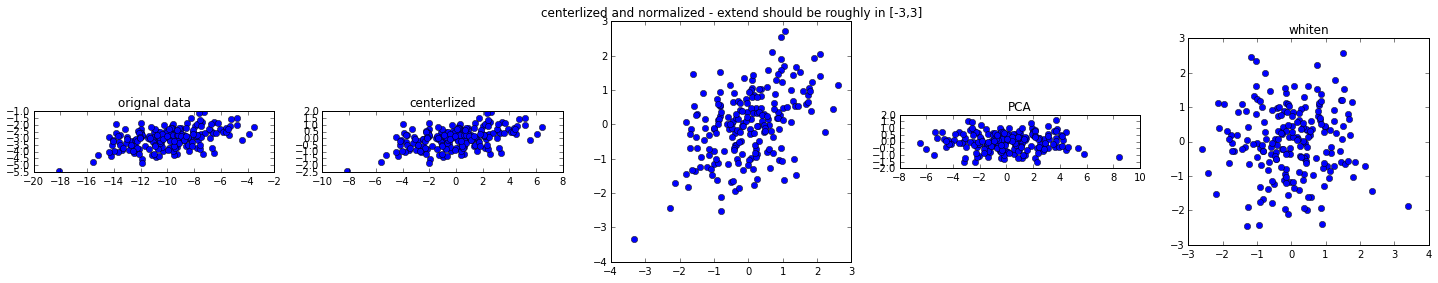

In [8]:
X = np.random.multivariate_normal(mean = [-10, -3], cov = np.array([[6., 0.8], [0.8, 0.5]]), size = 200)

fig, axes = plt.subplots(1, 5, figsize = (25, 5))
axes[0].plot(X[:, 0], X[:, 1], "o")
axes[0].set_title("orignal data")
axes[0].set_aspect('equal', adjustable='box')

centeredX = subtract_mean(X)
axes[1].plot(centeredX[:, 0], centeredX[:, 1], "o")
axes[1].set_title("centerlized")
axes[1].set_aspect('equal', adjustable='box')

normalX = normalize(X)
axes[2].plot(normalX[:, 0], normalX[:, 1], "o")
axes[2].set_title("centerlized and normalized - extend should be roughly in [-3,3]")
axes[2].set_aspect('equal', adjustable='box')

pcaX = PCA(X)
axes[3].plot(pcaX[:, 0], pcaX[:, 1], "o")
axes[3].set_title("PCA")
axes[3].set_aspect('equal', adjustable='box')

whiteX = whiten(X, n_components=None)
axes[4].plot(whiteX[:, 0], whiteX[:, 1], "o")
axes[4].set_title("whiten")
axes[4].set_aspect('equal', adjustable='box')

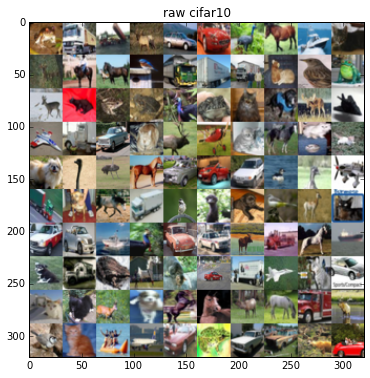

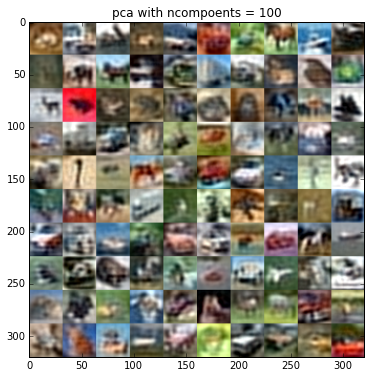

In [9]:
images = cifar_train_images

def PCAimages(images, n_components = 100):
    mean_images = images.mean(axis = 0)
    X = images - mean_images
    U, S, V = np.linalg.svd(np.dot(X.T, X))
    pca_images = np.dot(np.dot(X, U[:, :n_components]), U.T[:n_components, :])
    pca_images += mean_images
    pca_images[pca_images < 0] = 0
    pca_images[pca_images > 255] = 255
    return pca_images


def draw_images(images, nrow, ncol):
    H, W, C = 32, 32, 3
    canvas = np.zeros((nrow*H, ncol*W, C), dtype=np.uint8)
    for r in xrange(nrow):
        for c in xrange(ncol):
            canvas[H*r:H*(r+1), W*c:W*(c+1), :] = images[r*ncol + c].reshape((H, W, C))
    plt.figure(figsize = (6, 6))
    plt.imshow(canvas)
    return canvas
    
_ = draw_images(images[:100], 10, 10)
plt.title("raw cifar10")

pca_images = PCAimages(images)
_ = draw_images(pca_images[:100], 10, 10)
plt.title("pca with ncompoents = 100")



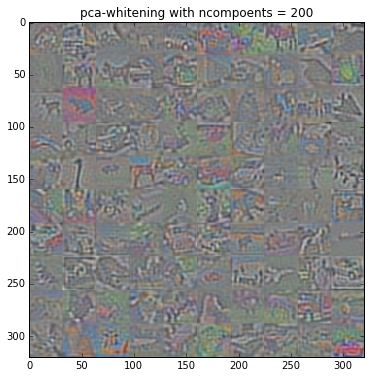

In [10]:

def whiten_images(images, n_components = 100):
    mean_images = images.mean(axis = 0)
    X = images - mean_images
    U, S, V = np.linalg.svd(np.dot(X.T, X))
    pca_images = np.dot(np.dot(X, U[:, :n_components]) / np.sqrt(S[:n_components]+1e-6) , U.T[:n_components, :])
    ## orignal mean values are meaningless now, instead, do normalization
    #pca_images += mean_images
    pca_images = (pca_images-pca_images.min())*255 / (pca_images.max()-pca_images.min())
    pca_images[pca_images < 0] = 0
    pca_images[pca_images > 255] = 255
    return pca_images

white_images = whiten_images(images, n_components=200)
_ = draw_images(white_images[:100], 10, 10)
plt.title("pca-whitening with ncompoents = 200")

The whitened images are more colorless, as each dimension (including different color channels) are made more similiar in ranges

## Neural Networks

### 3. Learning and Evaluation (dynamics of training NN)

The course notes of (this chapter)[http://cs231n.github.io/neural-networks-3/] contains a lot of details and practical recommendations when you are implementing a network. We don't have a "brief version" here because we recommend to read **everything** in the original note.

Some tricks for "coding" derivatives:
- Most derivative calculation (backward) will depend on the result of forward calculation. Additionally, the derivation expression are usually represented in a better form by the forward results.
- Try to break the forward/backward calculations, for each the derivatives should easy to compute
- The emprical statistics usually come in a form of $\sum_{i}f_i(w)$, it is almost always good enough to derive $\frac{\partial f_i}{\partial w}$ and then sum it up
- the chain rule introduced in the course is enough for most of the derivative computation. However, it usually makes sense to memorize some most common results for their intuitive explaination, e.g., the derivative of softmax cross-entropy w.r.t. score is the probability delta vector that "makes the right prediction probability 1 and all others 0" (see below for details)
- always use ***empirical check*** to help you debug

## Example of a Mini Network

Exercise of [code](http://cs231n.github.io/neural-networks-case-study/) here

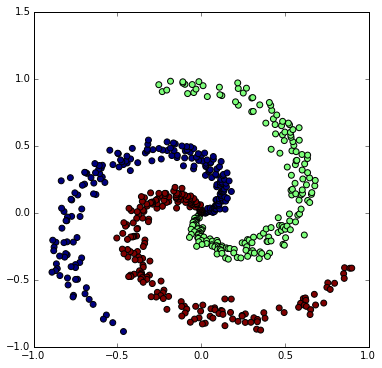

In [33]:
## generate spiral data

## 200 2-D points with 3 classes
N, D, K = 200, 2, 3
X = np.zeros( (N*K, D), dtype = np.float32)
y = np.zeros( N*K, dtype = np.uint8)

for cls in xrange(K):
    ## index
    ix = range(cls*N, (cls+1)*N)
    ## radius and theta
    r = np.linspace(0, 1., N)
    t = np.linspace(cls*4, (cls+1)*4, N) + np.random.randn(N)*0.2 # jitter
    X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
    y[ix] = cls

plt.figure(figsize = (6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s = 35)

## preprocess to center and normalize features
## not needed here as it is already so

### Linear Models

In [35]:
## BUILDING BLOCKS - INITALIZATION OF MODELS, SCORES/LOSS CALCUATION, GRADIENT CALCULATION/UPDATES

## train a softmax linear classifier
## the original code represents the W and b as the transpose format, 
## but here we find the following encoding works more intutively for us

## parameter initialization - W (K x D) and b (K x 1)
W = np.sqrt(2./D) * np.random.randn(K, D)
b = np.zeros((K, 1))
model = (W, b)

## calcuate the scores - forward chain of multiple steps.
## later it will become natural to reverse these steps in backprogagation.
## So as a thumb-of-rule, organize the calculations into steps so that
## at each of them the derivatives are easy to derive.
def calculate_scores(model, X):
    """W = (K, D), X = (N, D)"""
    W, b = model
    scores = np.dot(W, X.T) + b
    return scores
def calculate_probs(scores):
    """scores = (K, N)"""
    probs = scores - scores.max(axis = 0)
    probs = np.exp(probs)
    probs /= probs.sum(axis = 0)
    #probs = probs[y, range(y.shape[0])]
    return probs
def calculate_data_loss(probs, y):
    """probs = (K, N)"""
    probs = probs[y, range(y.shape[0])]
    data_loss = (-np.log(probs)).mean()
    return data_loss
def calculate_norm_penalty(model):
    W, _ = model
    return (0.5 * (W*W)).sum()
def calcualte_total_loss(data_loss, norm_penalty, lmbda):
    return data_loss + lmbda * norm_penalty

## convient function of whole forward calcuation
def forward(model, X, y, lmbda):
    scores = calculate_scores(model, X)
    probs = calculate_probs(scores)
    data_loss = calculate_data_loss(probs, y)
    norm_penalty = calculate_norm_penalty(model)
    total_loss = calcualte_total_loss(data_loss, norm_penalty, lmbda)
    return scores, probs, data_loss, norm_penalty, total_loss
    

## sanity check - calling calcuate_softmax_entropy on intial W, b values
## should give the loss ~= 1.1, which is -np.log(1./3) for K = 3, later
## we want to reduce the loss to as low as zero
print calculate_data_loss(calculate_probs(calculate_scores(model, X)), y)
print (forward(model, X, y, 0.01))[1].shape

## caculate the gradients
def calculate_gradients(model, X, y, lmbda, forward_results):
    W, b = model
    scores, probs, data_loss, norm_penalty, total_loss = forward_results
    N, D = X.shape
    ## chain rule - backward of the previous defined forward chain
    ## intialization
    dtotal_loss = 1.
    dW, db = np.zeros_like(W), np.zeros_like(b)
    ## from calculate_total_loss
    ddata_loss = dtotal_loss
    dnorm_penalty = lmbda * dtotal_loss
    ## from calculate_norm_penalty
    dW += dnorm_penalty * W

#     ## from calcualte_data_loss and calculate probs 
#     dprobs = -ddata_loss / N / probs
#     dscores = -probs * probs
#     dscores[y, range(N)] =  probs[y, range(N)] * (1 - probs[y, range(N)])
#     dscores = dprobs * dscores
    ## ALTERNATIVELY - MEMORIZE IT!! And the calculation is much opitmized
    ## d(softmax_crossentropy)/d(score) = p - y, where p is prediction probablity 
    ## and y is the target probability (one-hot encoding)
    dscores = probs 
    dscores[y, range(N)] -= 1
    dscores /= N
    dscores *= ddata_loss
    # from calculate_scores
    dW += np.dot(dscores, X)
    db += dscores.sum(axis = 1).reshape((-1, 1))
    
    return dW, db

## sanity check of derivatives
def empirical_gradients(model, X, y, lmbda, delta = 1e-5):
    W0, b0 = model
    dW, db = np.zeros_like(W0), np.zeros_like(b0)
    wr, wc = dW.shape
    for r in xrange(wr):
        for c in xrange(wc):
            W0[r, c] -= delta
            y1 = forward( (W0, b0), X, y, lmbda )[-1]
            W0[r, c] += 2*delta
            y2 = forward( (W0, b0), X, y, lmbda )[-1]
            dW[r, c] = (y2-y1) / delta / 2
            W0[r, c] -= delta
    for b in xrange(b0.shape[0]):
        b0[b, 0] -= delta
        y1 = forward( (W0, b0), X, y, lmbda )[-1]
        b0[b, 0] += 2*delta
        y2 = forward( (W0, b0), X, y, lmbda )[-1]
        db[b, 0] = (y2-y1) / delta / 2
        b0[b, 0] -= delta
    return dW, db
dW, db = calculate_gradients(model, X, y, 0.01, forward(model, X, y, 0.01))
edW, edb = empirical_gradients(model, X, y, 0.01)
print np.allclose(dW, edW), np.allclose(db, edb) ## not really the recommended way - should USE relative closeness

1.07721668642
(3, 600)
True True


In [36]:
## utility functions to evaluate prediction result
def predict(model, X):
    W, b = model
    scores = np.dot(W, X.T) + b
    yhat = scores.argmax(axis = 0)
    return yhat

def classification_rate(y, yhat):
    return np.mean(y==yhat)

def plot_result(X, y, model):
    h = 0.02
    x0min, x0max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1min, x1max = X[:, 1].min() - 1, X[:, 1].max() + 1
    aa, bb = np.meshgrid(np.arange(x0min, x0max, h), 
                         np.arange(x1min, x1max, h))
    Z = predict(model, np.c_[aa.ravel(), bb.ravel()])
    Z = Z.reshape(aa.shape)
    fig = plt.figure(figsize = (6, 6))
    plt.contourf(aa, bb, Z, cmap = plt.cm.Spectral, alpha = 0.8)
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 30, cmap = plt.cm.Spectral)
    plt.xlim(aa.min(), aa.max())
    plt.ylim(bb.min(), bb.max())

iteration 0 loss 1.024955
iteration 10 loss 0.872208
iteration 20 loss 0.814850
iteration 30 loss 0.790327
iteration 40 loss 0.778277
iteration 50 loss 0.771652
iteration 60 loss 0.767700
iteration 70 loss 0.765204
iteration 80 loss 0.763563
iteration 90 loss 0.762452
iteration 100 loss 0.761683
iteration 110 loss 0.761142
iteration 120 loss 0.760755
iteration 130 loss 0.760475
iteration 140 loss 0.760271
iteration 150 loss 0.760119
iteration 160 loss 0.760005
iteration 170 loss 0.759918
iteration 180 loss 0.759852
iteration 190 loss 0.759800
classification accuracy by linear model: 0.525


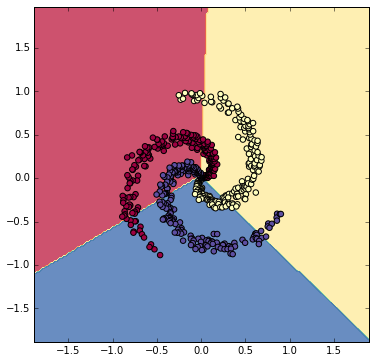

In [37]:
## putting forward and backward into a optimization loop

## train a classifier 
W = np.sqrt(2./D) * np.random.randn(K, D)
b = np.zeros((K, 1))
model = (W, b)

learning_rate = 1e-0
lmbda = 1e-3
niterations = 200

for i in xrange(niterations):
    forward_result = forward(model, X, y, lmbda)
    dW, db = calculate_gradients(model, X, y, lmbda, forward_result)
    if i % 10 == 0:
        print "iteration %d loss %f" % (i, forward_result[-1])
    W += -learning_rate * dW
    b += -learning_rate * db
    model = (W, b)

yhat = predict(model, X)
print "classification accuracy by linear model:", classification_rate(y, yhat)
plot_result(X, y, model)

###Training A Neural Network

One additional layer of weights with ReLU would be enough for the data

In [96]:
nhiddens = 5
W1 = np.random.randn(nhiddens, D) * np.sqrt(2. / D)
b1 = np.zeros( (nhiddens, 1) )
W2 = np.random.randn(K, nhiddens) * np.sqrt(2. / nhiddens)
b2 = np.zeros( (K, 1) )
model = (W1, b1, W2, b2)

def calculate_layer1_scores(model, X):
    W1, b1, W2, b2 = model
    return np.dot(W1, X.T) + b1 # nhiddens x N
def calculate_layer1_activations(layer1_scores):
    return np.maximum(0, layer1_scores) # nhiddens x N
def calculate_layer2_scores(model, layer1_activations):
    W1, b1, W2, b2 = model
    return np.dot(W2, layer1_activations) + b2 # K x N
def calculate_layer2_probs(layer2_scores):
    probs = layer2_scores - layer2_scores.max(axis = 0)
    probs = np.exp(probs)
    probs /= probs.sum(axis = 0)
    return probs
def calculate_data_loss(layer2_probs, y):
    data_loss = layer2_probs[y, range(layer2_probs.shape[1])]
    data_loss = -np.log(data_loss).mean()
    return data_loss
def calculate_norm_penalty(model):
    W1, b1, W2, b2 = model
    return .5 * ((W1*W1).sum() + (W2*W2).sum())
def calculate_total_loss(data_loss, norm_penalty, lmbda):
    return data_loss + norm_penalty * lmbda
def forward(model, X, y, lmbda):
    layer1_scores = calculate_layer1_scores(model, X)
    layer1_activations = calculate_layer1_activations(layer1_scores)
    layer2_scores = calculate_layer2_scores(model, layer1_activations)
    layer2_probs = calculate_layer2_probs(layer2_scores)
    data_loss = calculate_data_loss(layer2_probs, y)
    norm_penalty = calculate_norm_penalty(model)
    total_loss = calculate_total_loss(data_loss, norm_penalty, lmbda)
    return layer1_scores, layer1_activations, layer2_scores, layer2_probs, data_loss, norm_penalty, total_loss

## santity check - the initial data loss should be around -np.log(1./3) = 1.1
print forward(model, X, y, 0.01)[-3]

def backward(model, X, y, lmbda, forward_results):
    N, D = X.shape
    layer1_scores, layer1_activations, layer2_scores, layer2_probs, data_loss, norm_penalty, total_loss = forward_results
    W1, b1, W2, b2 = model
    ## initialization
    dW1 = np.zeros_like(W1)
    db1 = np.zeros_like(b1)
    dW2 = np.zeros_like(W2)
    db2 = np.zeros_like(b2)
    dtotal_loss = 1.
    ## total_loss -> data_loss, norm_penalty
    ddata_loss = dtotal_loss
    dnorm_penalty = lmbda * dtotal_loss
    ## dnorm_penalty -> dW1, dW2
    dW1 += dnorm_penalty * W1
    dW2 += dnorm_penalty * W2
    ## ddata_loss -> layer2_scores in one step
    dlayer2_scores = layer2_probs
    dlayer2_scores[y, range(N)] -= 1
    dlayer2_scores /= N
    dlayer2_scores *= ddata_loss
    ## layer2_scores -> dlayer1_activations, dW2, db2
    dW2 += np.dot(dlayer2_scores, layer1_activations.T)
    db2 += dlayer2_scores.sum(axis = 1).reshape((-1, 1))
    dlayer1_activations = np.dot(W2.T, dlayer2_scores)
    ## layer1_activations -> layer1_scores
    #dlayer1_scores = np.where(layer1_scores > 0, dlayer1_activations, 0)
    dlayer1_scores = dlayer1_activations * (layer1_scores > 0)
    ## layer1_scores -> dW1, db1
    dW1 += np.dot(dlayer1_scores, X)
    db1 += dlayer1_scores.sum(axis = 1).reshape((-1, 1))
    return (dW1, db1, dW2, db2)

## sanity check of derivatives
def empirical_gradients(model, X, y, lmbda, delta = 1e-5):
    dmodels = []
    for i in xrange(len(model)):
        dmodels.append(np.zeros_like(model[i]))
        for r in xrange(model[i].shape[0]):
            for c in xrange(model[i].shape[1]):
                model[i][r, c] -= delta
                y1 = forward(model, X, y, lmbda)[-1]
                model[i][r, c] += 2*delta
                y2 = forward(model, X, y, lmbda)[-1]
                dmodels[i][r, c] = (y2-y1)/delta/2
                model[i][r, c] -= delta
    return dmodels
    
dW1, db1, dW2, db2 = backward(model, X, y, 0.01, forward(model, X, y, 0.01))
edW1, edb1, edW2, edb2 = empirical_gradients(model, X, y, 0.01)
## AGAIN not really the recommended way - should USE relative closeness 
def allclose(a, b):
    e = np.abs(a-b) / (np.abs(a) + np.abs(b))
    #1e-3 tolerance should be OK for kinks in objective, e.g., ReLU
    return np.allclose(e, 0, atol=1e-3)
print allclose(dW1, edW1), allclose(db1, edb1), allclose(dW2, edW2), allclose(db2, edb2) 

## prediction method
def predict(model, X):
    W1, b1, W2, b2 = model
    layer1 = np.maximum(0, np.dot(W1, X.T) + b1)
    layer2 = np.dot(W2, layer1) + b2
    yhat = layer2.argmax(axis = 0)
    return yhat

1.07094272054
True True True True


iteration 0 loss 2.345464
iteration 1000 loss 0.301371
iteration 2000 loss 0.244148
iteration 3000 loss 0.240969
iteration 4000 loss 0.240340
iteration 5000 loss 0.240007
iteration 6000 loss 0.239804
iteration 7000 loss 0.239685
iteration 8000 loss 0.239604
iteration 9000 loss 0.239541
classification accuracy by linear model: 0.995


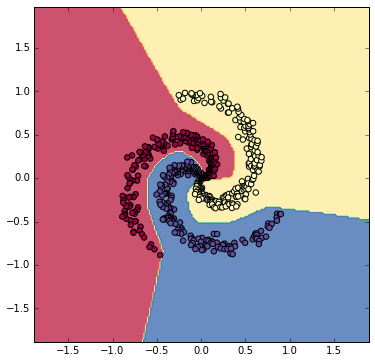

In [98]:
## putting forward and backward in a training loop
## a hidden nubmer of 100 is recommened, actually smaller number such as 10 is enough for such
## a toy problem. Here a large number was picked to show that with enough regluarlization
## the number of hidden neurons should only be limited by the computing resource
nhiddens = 1000
W1 = np.random.randn(nhiddens, D) * np.sqrt(2. / D)
b1 = np.zeros( (nhiddens, 1) )
W2 = np.random.randn(K, nhiddens) * np.sqrt(2. / nhiddens)
b2 = np.zeros( (K, 1) )
model = (W1, b1, W2, b2)

learning_rate = 1e-0
lmbda = 1e-3
niterations = 10000

for i in xrange(niterations):
    forward_result = forward(model, X, y, lmbda)
    dW1, db1, dW2, db2 = backward(model, X, y, lmbda, forward_result)
    if i % 1000 == 0:
        print "iteration %d loss %f" % (i, forward_result[-1])
    W1 += -learning_rate * dW1
    b1 += -learning_rate * db1
    W2 += -learning_rate * dW2
    b2 += -learning_rate * db2
    model = (W1, b1, W2, b2)

yhat = predict(model, X)
print "classification accuracy by linear model:", classification_rate(y, yhat)
plot_result(X, y, model)